# WP1 - Anomaly Propagation Subgraph Extraction

In [103]:
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import networkx.algorithms.isomorphism as iso
import os

from anomaly_detection import detect_anomalies
import temporal_graph_generation as tgg
import correlation

In [104]:
reload(tgg)

<module 'temporal_graph_generation' from '/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/temporal_graph_generation.py'>

In [105]:
#manually load and import cloned overtime repository
os.getcwd()
os.chdir("../overtime")
import overtime
os.chdir("../src")

### 1. Read GraphML file for system graph with causality information

In [70]:
graph = nx.read_graphml("../data/causality_chi2.graphml")
graph = graph.to_undirected()
graph = nx.convert_node_labels_to_integers(graph)

/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id id. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id causal. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id label. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")


In [127]:
graph.nodes[13]['id']

'front-end'

In [125]:
system_graph = nx.read_graphml("../data/Sock-shop.graphml")
system_graph = nx.convert_node_labels_to_integers(system_graph)

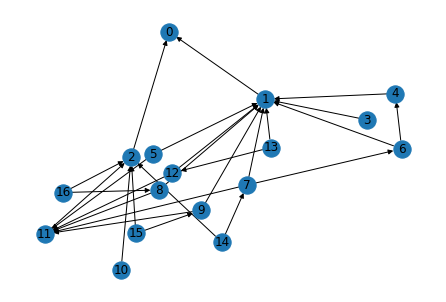

In [43]:
nx.draw(system_graph, nx.spring_layout(system_graph, seed=42), with_labels=True)

### 2. Get and Add Anomaly Information for System Graph based on Domain Knowledge
anomaly is injected at ```frontend``` node with anomalies given on '2/17/2022' and '3/2/2022' 

In [44]:
full_data = pd.read_csv('../data/loadtest-timestamp.csv')
full_data[['Date', 'Time']] = full_data['Time'].str.split(" ", expand=True)
full_data = full_data.sort_values(by=['Date','Time'])
full_data.head()

,Unnamed: 0,Time,carts,carts-db,catalogue,catalogue-db,front-end,orders,orders-db,payment,queue-master,rabbitmq,session-db,shipping,user,user-db,Date
674,674,11:27,0.00245,0.00824,0.00129,0.00115,0.00313,0.00260,0.00901,0.00125,0.00254,0.0145,0.00232,0.00223,0.00178,0.00942,10/14/2021
675,675,11:28,0.00279,0.01020,0.00128,0.00108,0.00352,0.00273,0.00974,0.00131,0.00249,0.0136,0.00268,0.00235,0.00191,0.01060,10/14/2021
676,676,11:29,0.00345,0.00929,0.00140,0.00118,0.00379,0.00262,0.00938,0.00137,0.00329,0.0132,0.00260,0.00214,0.00198,0.01020,10/14/2021
677,677,11:30,0.00233,0.00890,0.00108,0.00112,0.00343,0.00227,0.00783,0.00130,0.00239,0.0113,0.00223,0.00221,0.00173,0.00869,10/14/2021
678,678,11:31,0.00421,0.00914,0.00148,0.00138,0.00405,0.00297,0.00980,0.00141,0.00250,0.0127,0.00259,0.00234,0.00233,0.01030,10/14/2021


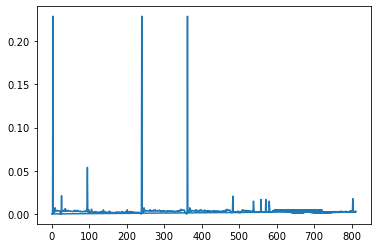

In [45]:
plt.plot(full_data['front-end'])

In [ ]:
#error at data node is expected (not enough information given)
detect_anomalies(full_data, graph, ['2/17/2022', '3/2/2022'], ['10/14/2021', '10/19/2021', '10/20/2021'])

In [129]:
#only keep causal edges in graph for anomaly propagation subgraph extraction
remove_edges = [e for e in graph.edges(data=True) if e[2].get('causal')!='true']
graph.remove_edges_from(remove_edges) #inplace

In [130]:
graph

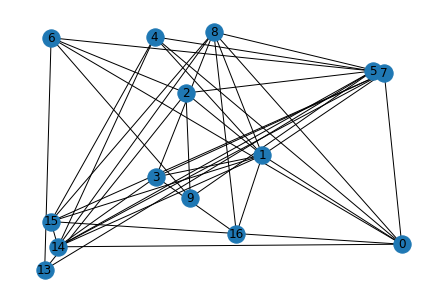

In [131]:
#remove isolated nodes for better visualization
graph.remove_nodes_from(list(nx.isolates(graph)))
nx.draw(graph, nx.random_layout(graph), with_labels=True)

### 3. Sample APG subgraphs with dfs/bfs tree combination

In [132]:
MAXLAG = 2
DATETIME_FORMAT = "%m/%d/%Y %H:%M"

frontend_node = [n for n in graph.nodes.data() if n[1]["id"] == "front-end"][0]

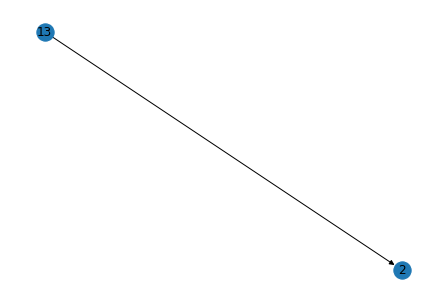

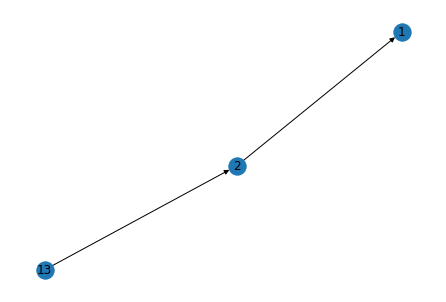

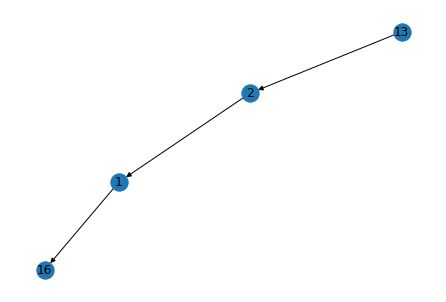

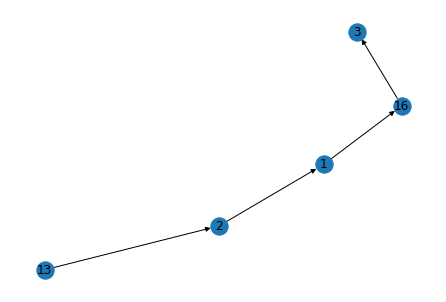

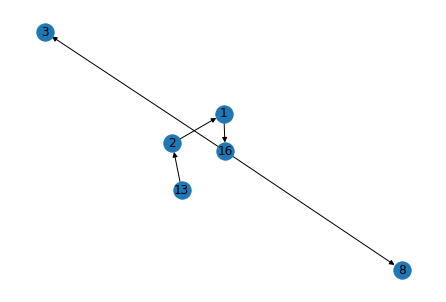

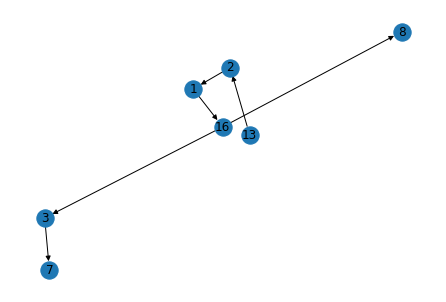

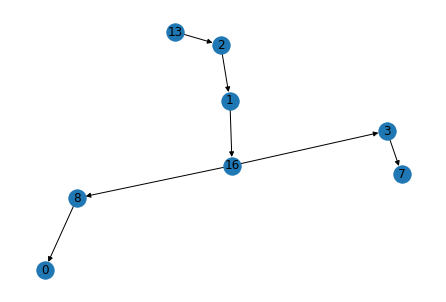

In [133]:
#visualize subgraph sampling
# def get_subgraph(t):
np.random.seed(112)
subgraph=nx.DiGraph()
subgraph.add_node(frontend_node[0])
nodes_to_visit = [frontend_node[0]]
max_nodes = 8
#assert max_nodes>0, 'enter positive max_nodes'
for node in nodes_to_visit:
    potential_next_nodes = []
    potential_next_nodes = [n for n in list(graph.neighbors(node)) if not n in nodes_to_visit]
    if len(potential_next_nodes) > 0:
        if np.random.choice([0, 1], p=[1-0.5, 0.5]):
            # bfs way
            next_nodes = potential_next_nodes
        else:
            # dfs way
            next_nodes = [potential_next_nodes[np.random.choice(len(potential_next_nodes))]]
        
        num_nodes_to_add = np.minimum(max_nodes-len(subgraph.nodes()), len(next_nodes))
        next_nodes = next_nodes[:num_nodes_to_add]
        nodes_to_visit += next_nodes
        for next_node in next_nodes:
            subgraph.add_node(next_node)
            subgraph.add_edge(node, next_node)
            plt.figure(node+next_node)
            nx.draw(subgraph, with_labels=True)
    #     if len(subgraph.nodes())>=max_nodes:
    #         return subgraph
    # return subgraph        
       

In [79]:
nodes = [graph.nodes.data()[i]['id'] for i,n in enumerate(graph.nodes.data())]

In [82]:
node_num = len(nodes)
temporal_steps = 8

In [97]:
import matplotlib.animation as plta
from pathlib import Path

fig, ax = plt.subplots(figsize=(16,9))
def draw(frame):
    t = frame % temporal_steps
    subgraph: nx.DiGraph = get_subgraph(t)
    subgraph = nx.relabel_nodes(subgraph, { k: nodes[k] for i, k in enumerate(subgraph.nodes) })
    nx.draw_circular(subgraph, with_labels=True, ax=ax)
ani = plta.FuncAnimation(fig, draw, frames=temporal_steps, interval=1000, repeat=True)
ani.save("../data/bfs_dfs_generated.gif")
plt.close(fig)

3.1. Check subgraph that can be extracted based on real anomaly timestamps in system graph

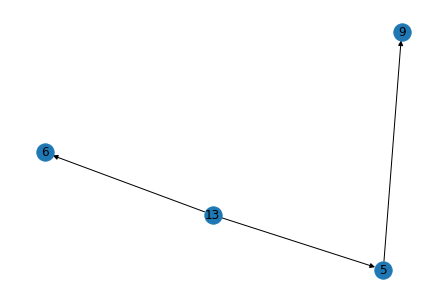

In [14]:
tg= tgg.sample_subgraph_with_timestamp_constraint(graph, frontend_node[0], bfs_prob=0.5, random_seed=111, start_timestamp='3/2/2022 13:22', datetime_format=DATETIME_FORMAT, maxlag=MAXLAG)
nx.draw(tg, with_labels=True)

3.2. Sample a large number of possible temporal subgraphs from system graph between 2 and maximum amount of nodes with multiple possible temporal combinations
(Caution: this may take quite a long time)

In [ ]:
tn_subgraphs = tgg.sample_temporal_subgraphs(graph, frontend_node[0])

In [ ]:
np.save('../data/apg_unique_subgraphs_temporal_node2-17.npy', correlation.encode_temporal_graphs(tn_subgraphs))

In [ ]:
len(tn_subgraphs)

Sample visualizations of temporal subgraphs

In [106]:
read_apg = correlation.decode_temporal_graphs(np.load('../data/apg_unique_subgraphs_temporal_node2-17.npy'))

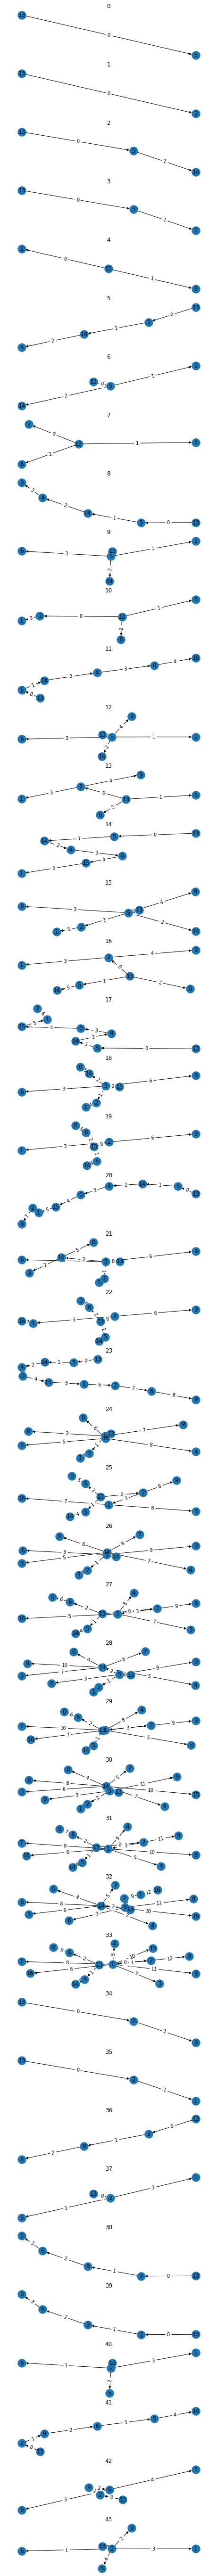

In [107]:
fig, axes = plt.subplots(44, 1, figsize=(8,100))
for i, subgraph in enumerate(read_apg[:44]):
    nx.draw(subgraph, nx.spring_layout(subgraph, seed=7), with_labels=True, ax=axes[i])
    axes[i].set_title(i)
    edge_labels = nx.get_edge_attributes(subgraph, "timestep")
    nx.draw_networkx_edge_labels(subgraph, nx.spring_layout(subgraph, seed=7), edge_labels, ax=axes[i])

In [108]:
subgraph_nodes = [len(sg.nodes) for sg in read_apg]

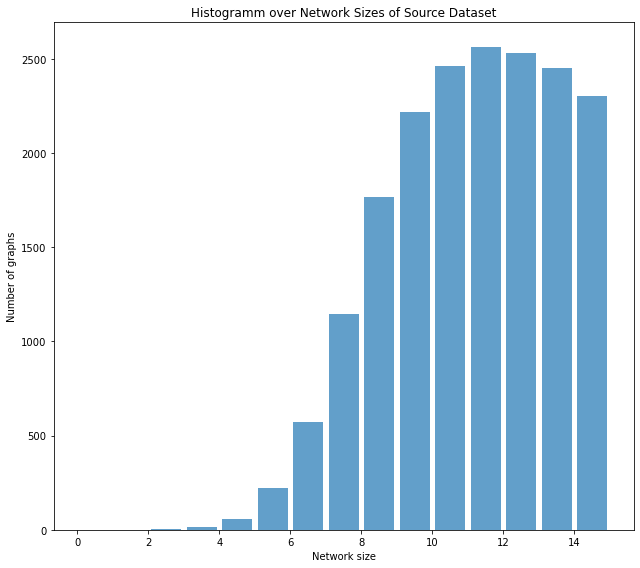

In [120]:
plt.figure(figsize=(9,8))
plt.hist(subgraph_nodes, alpha=0.7, rwidth=0.85, bins=np.arange(16))
plt.xlabel("Network size")
plt.ylabel("Number of graphs")
plt.title("Histogramm over Network Sizes of Source Dataset")
plt.tight_layout()

(array([  17.,   57.,  220.,  570., 1144., 3987., 2464., 2565., 2533.,
        4755.]),
 array([ 2. ,  3.2,  4.4,  5.6,  6.8,  8. ,  9.2, 10.4, 11.6, 12.8, 14. ]),
 <BarContainer object of 10 artists>)

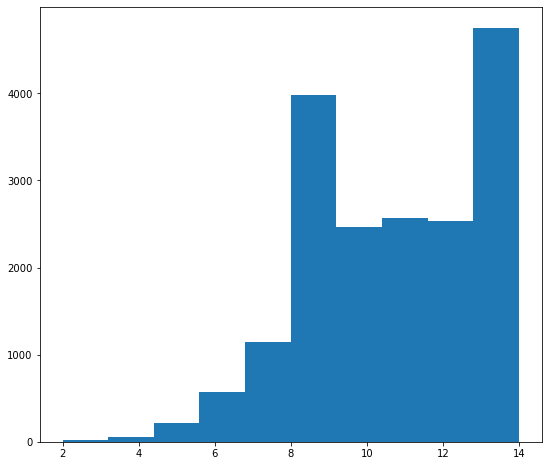

In [119]:
plt.figure(figsize=(9,8))
plt.hist(subgraph_nodes)

(array([  17.,   57.,  220.,  570., 1144., 3987., 2464., 2565., 2533.,
        4755.]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <BarContainer object of 10 artists>)

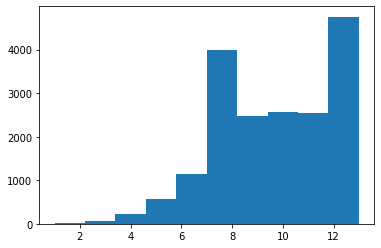

In [6]:
subgraph_sizes = [sg.size() for sg in read_apg]
plt.hist(subgraph_sizes)

### Test temporal centralities with teneto package

In [ ]:
edge_df = nx.to_pandas_edgelist(subgraph)
edge_df.columns = ['i','j','t']
edge_df = edge_df.replace(to_replace=r'^n', value='', regex=True)
edge_df = edge_df.apply(pd.to_numeric)
edge_df

In [ ]:
add_edges = []
max_time = np.max(edge_df['t'])
for i in edge_df.index:
    row = edge_df.iloc[i]
    times_to_add = np.arange(row["t"], max_time+1)
    for t_to_add in times_to_add:
        add_edges.append([row["i"], row["j"], t_to_add])

In [ ]:
fill_edges = pd.DataFrame(add_edges, columns=edge_df.columns)
fill_edges

In [ ]:
import teneto

tnet = teneto.TemporalNetwork(from_df=fill_edges)

In [ ]:
closeness_centrality =  teneto.networkmeasures.temporal_closeness_centrality(tnet=tnet)

In [ ]:
#degree centrality
pd.Series(teneto.networkmeasures.temporal_degree_centrality(tnet=tnet))

In [ ]:
betweenness_centrality =  teneto.networkmeasures.temporal_betweenness_centrality(tnet=tnet)
betweenness_centrality

### Test temporal centralities with overtime package

In [12]:
subgraph = read_apg[30] # example subgraph
edge_df = nx.to_pandas_edgelist(subgraph)
max_time = np.max(edge_df['timestep'])

temporal_network = overtime.TemporalDiGraph("test_network")
for node in subgraph.nodes():
    temporal_network.add_node(node)
for _, edge in edge_df.iterrows():
    temporal_network.add_edge(str(edge["source"]), str(edge["target"]), edge["timestep"] + 1, max_time + 2)

In [ ]:
np.max(edge_df['timestep'])

In [13]:
edge_df

,source,target,timestep
0,13,5,0
1,5,2,1
2,5,14,2
3,5,6,3
4,5,9,11
5,2,1,9
6,14,0,4
7,14,3,6
8,14,4,7
9,14,7,5


In [14]:
tc_fastest = overtime.temporal_betweenness(temporal_network, optimality="shortest")
tc_fastest

{'13': 0.0,
 '15': 0,
 '14': 12.0,
 '7': 0,
 '0': 0,
 '4': 0,
 '9': 0,
 '6': 0,
 '1': 0,
 '2': 2.0,
 '8': 0,
 '3': 0,
 '5': 11.0}

In [ ]:
#plot temporal graph with centrality attributes via overtime visualization methods
# labels = []
# for t in range(temporal_network.edges.start(), temporal_network.edges.end()):
#     print(t)
#     figure, axes = plt.subplots(1)
#     labels.append('examples/time_' + str(t) + '.png')
#     print(temporal_network.get_snapshot(t))
#     overtime.plots.circle.Circle(temporal_network.get_snapshot(t), axes)

labels = []
for t in temporal_network.edges.timespan():
    figure, axes = plt.subplots(1)
    labels.append('examples/time_' + str(t) + '.png')
    overtime.plots.circle.Circle(temporal_network.get_snapshot(t), axes)
    figure.savefig(labels[-1], format='png')

### Calculate temporal centrality vectors for list of graphs

In [23]:
temporal_closeness_vectors_t = []
temporal_betweenness_vectors_t = []
temporal_degree_vectors_t = []
max_nodes = len(graph.nodes()) 

for s in read_apg:
    edge_df = nx.to_pandas_edgelist(s)
    max_time = np.max(edge_df['timestep'])

    temporal_network = overtime.TemporalDiGraph("test_network")
    for node in s.nodes():
        temporal_network.add_node(node)
    for _, edge in edge_df.iterrows():
        temporal_network.add_edge(str(edge["source"]), str(edge["target"]), edge["timestep"] + 1, max_time + 2)
    
    closeness_centrality = np.zeros((max_nodes))
    closeness_centrality_dict = overtime.temporal_closeness(temporal_network, optimality="fastest")
    closeness_centrality[list(map(int, closeness_centrality_dict.keys()))] = list(closeness_centrality_dict.values())
    temporal_closeness_vectors_t.append(closeness_centrality)

    betweenness_centrality = np.zeros((max_nodes))
    betweenness_centrality_dict = overtime.temporal_betweenness(temporal_network, optimality="foremost")
    betweenness_centrality[list(map(int, betweenness_centrality_dict.keys()))] = list(betweenness_centrality_dict.values())
    temporal_betweenness_vectors_t.append(betweenness_centrality)

    degree_centrality = np.zeros((max_nodes))
    degree_centrality_dict = overtime.temporal_degree(temporal_network, in_out='out') #out-degree centrality
    degree_centrality[list(map(int, degree_centrality_dict.keys()))] = list(degree_centrality_dict.values())
    temporal_degree_vectors_t.append(degree_centrality)

In [18]:
print(temporal_closeness_vectors_t[8])
print(temporal_closeness_vectors_t[13])
print(temporal_closeness_vectors_t[16])

[0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.33333333 0.         0.         0.        ]
[0.         0.         1.         0.         0.         1.48333333
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.        ]
[0.         0.         0.33333333 0.         0.         1.98333333
 0.         0.         0.         0.         0.         0.
 0.         1.         0.5        0.         0.        ]


In [19]:
print(temporal_betweenness_vectors_t[8])
print(temporal_betweenness_vectors_t[13])
print(temporal_betweenness_vectors_t[16])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 2. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 2. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0.]


In [20]:
temporal_degree_vectors_t[:5]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0.5, 0. , 0. , 0. ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.33333333, 0.33333333,
        0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.66666667, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 0.        ])]

In [21]:
np.save('../data/temporal_betweenness_vectors_overtime.npy',temporal_betweenness_vectors_t)

In [22]:
np.save('../data/temporal_closeness_vectors_overtime.npy',temporal_closeness_vectors_t)

In [23]:
np.save('../data/temporal_degree_vectors_overtime.npy', temporal_degree_vectors_t)

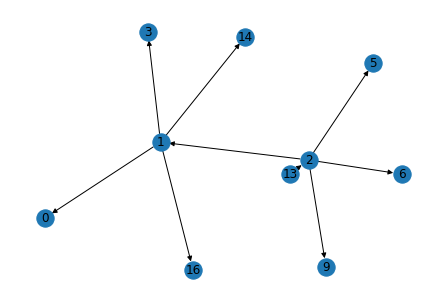

In [22]:
nx.draw(read_apg[40], with_labels=True)

In [24]:
print(temporal_closeness_vectors_t[40])
print(temporal_betweenness_vectors_t[40])
print(temporal_degree_vectors_t[40])

[0.         2.08333333 1.30119048 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.        ]
[0. 8. 8. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.44444444 0.44444444 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.11111111 0.         0.         0.        ]
